# Transfusion Data Set from UCI

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
    
[Link](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
# load dataframe
transfusion_df = pd.read_csv("../data/transfusion/transfusion.data",
                             names=["Recency (months)", "Frequency (times)", "Monetary (c.c. blood)", "Time (months)", "Donated"])
transfusion_df = transfusion_df.drop(transfusion_df.index[0])
transfusion_df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),Donated
1,2,50,12500,98,1
2,0,13,3250,28,1
3,1,16,4000,35,1
4,2,20,5000,45,1
5,1,24,6000,77,0


In [3]:
# check for null values
transfusion_df.isna().sum()

Recency (months)         0
Frequency (times)        0
Monetary (c.c. blood)    0
Time (months)            0
Donated                  0
dtype: int64

In [4]:
transfusion_df.dtypes

Recency (months)         object
Frequency (times)        object
Monetary (c.c. blood)    object
Time (months)            object
Donated                  object
dtype: object

In [5]:
# transform all columns to numeric type
transfusion_df = transfusion_df.apply(pd.to_numeric)

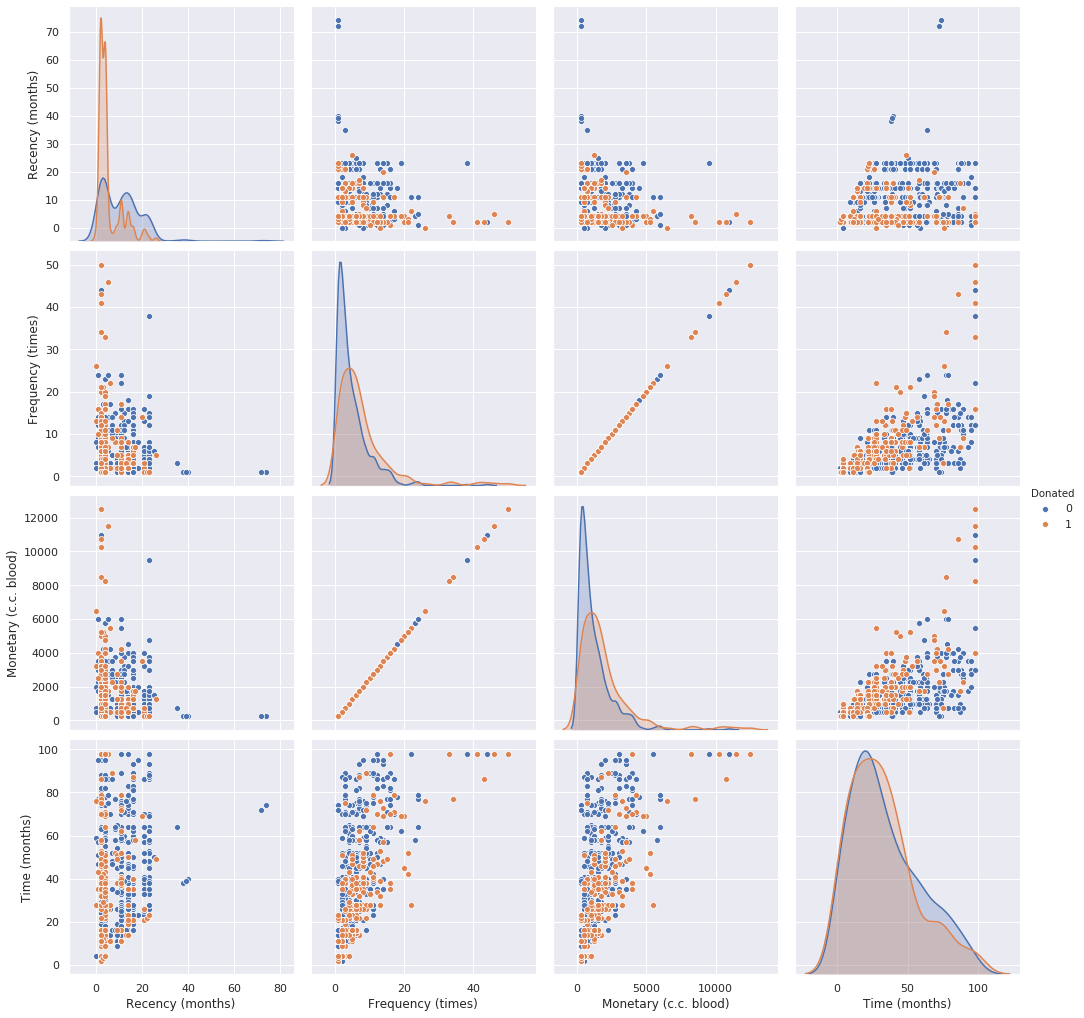

In [6]:
# Visualize data
sns.pairplot(transfusion_df, hue='Donated', height=3.5);

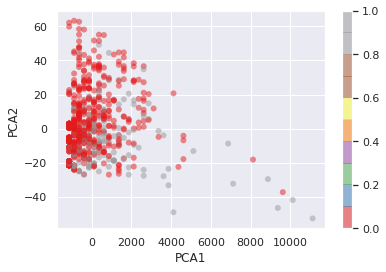

In [7]:
# Reduce dimensionality with PCA
from sklearn.decomposition import PCA

# instantiate model with 2 dimensions
pca = PCA(2)

# project from multiple to 2 dimensions
projected = pca.fit_transform(transfusion_df)

# plot
plt.scatter(projected[:,0], projected[:,1],
            c=transfusion_df["Donated"], edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Set1', 10))
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar();

## SVC

In [69]:
# Try to predict whether people donate with SVC
from sklearn.svm import SVC

np.random.seed(42)

# Shuffle data
transfusion_df_shuffled = transfusion_df.sample(frac=1)

# Create data
X = transfusion_df_shuffled.drop("Donated", axis=1)
y = transfusion_df_shuffled["Donated"]

# Split into train, validation, test
train_split = round(0.7 * len(X)) # 70% of data
valid_split = round(train_split + 0.15 * len(X)) # 15% of data
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[:valid_split]

# Fit model
svc_clf = SVC(kernel="rbf").fit(X_train, y_train)

### Model Evaluation

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds(y_true, y_preds):
    """
    Perform evaluation comparison on y_true labels vs. y_pred labels
    on a classifaction model.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average="micro")
    recall = recall_score(y_true, y_preds,average="micro")
    f1 = f1_score(y_true, y_preds, average="micro")
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precison: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [71]:
# Evaluate predictions

baseline_svc_y_preds = svc_clf.predict(X_valid)

baseline_svc_metrics = evaluate_preds(y_valid, baseline_svc_y_preds)

Accuracy: 80.36%
Precison: 0.80
Recall: 0.80
F1 score: 0.80


In [72]:
# Cross-Validation
from sklearn.model_selection import cross_val_predict, cross_val_score

scores = cross_val_score(svc_clf, X, y, cv=6)
scores

array([0.76      , 0.768     , 0.76      , 0.752     , 0.76612903,
       0.77419355])

In [73]:
cross_validated_svc_y_preds = cross_val_predict(svc_clf, X, y, cv=6)

cross_validated_metrics = evaluate_preds(y, cross_validated_svc_y_preds)

Accuracy: 76.34%
Precison: 0.76
Recall: 0.76
F1 score: 0.76


## Improving Model with RandomizedSearchCV

In [91]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.random.seed(44)

# Split data into features and target label
X = transfusion_df_shuffled.drop("Donated", axis=1)
y = transfusion_df_shuffled["Donated"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initiate grid
rs_svc_grid = {
    'C': [1, 3, 4],
    'gamma': ['scale', 'auto', 0.0004, 0.009, 0.001, 0.01]
}

# Instantiate SVC
svc_clf = SVC()

# Fit RandomizedSearchCV to model
rs_svc_clf = RandomizedSearchCV(estimator=svc_clf,
                            param_distributions=rs_svc_grid,
                            n_iter=10,
                            cv=5,
                            verbose=2)

rs_svc_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] gamma=0.001, C=1 ................................................
[CV] ................................. gamma=0.001, C=1, total=   0.0s
[CV] gamma=0.001, C=1 ................................................
[CV] ................................. gamma=0.001, C=1, total=   0.0s
[CV] gamma=0.001, C=1 ................................................
[CV] ................................. gamma=0.001, C=1, total=   0.0s
[CV] gamma=0.001, C=1 ................................................
[CV] ................................. gamma=0.001, C=1, total=   0.0s
[CV] gamma=0.001, C=1 ................................................
[CV] ................................. gamma=0.001, C=1, total=   0.0s
[CV] gamma=auto, C=1 .................................................
[CV] .................................. gamma=auto, C=1, total=   0.0s
[CV] gamma=auto, C=1 .................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ gamma=0.0004, C=4, total=   0.0s
[CV] gamma=0.0004, C=4 ...............................................
[CV] ................................ gamma=0.0004, C=4, total=   0.0s
[CV] gamma=0.0004, C=4 ...............................................
[CV] ................................ gamma=0.0004, C=4, total=   0.0s
[CV] gamma=0.0004, C=4 ...............................................
[CV] ................................ gamma=0.0004, C=4, total=   0.0s
[CV] gamma=0.009, C=1 ................................................
[CV] ................................. gamma=0.009, C=1, total=   0.0s
[CV] gamma=0.009, C=1 ................................................
[CV] ................................. gamma=0.009, C=1, total=   0.0s
[CV] gamma=0.009, C=1 ................................................
[CV] ................................. gamma=0.009, C=1, total=   0.0s
[CV] gamma=0.009, C=1 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [1, 3, 4],
                                        'gamma': ['scale', 'auto', 0.0004,
                                                  0.009, 0.001, 0.01]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [75]:
rs_svc_clf.best_params_

{'gamma': 0.001, 'C': 1}

In [76]:
# Evaluate model
rs_svc_y_preds = rs_svc_clf.predict(X_test)

rs_svc_metrics = evaluate_preds(y_test, rs_svc_y_preds)

Accuracy: 76.00%
Precison: 0.76
Recall: 0.76
F1 score: 0.76


#### Comparing metrics 

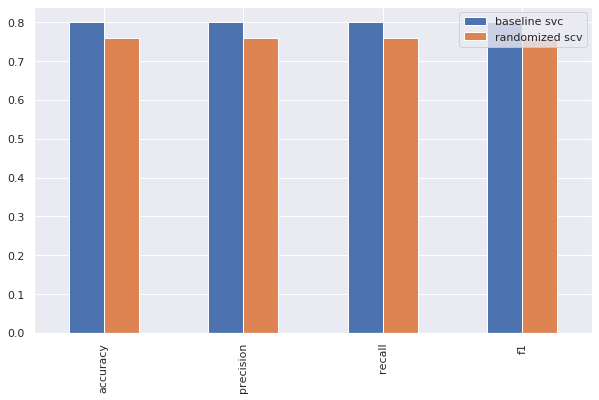

In [77]:
compare_svc_metrics = pd.DataFrame({
    'baseline svc': baseline_svc_metrics,
    'randomized scv': rs_svc_metrics
})

compare_svc_metrics.plot.bar(figsize=(10,6));

# RandomForestClassifier

In [78]:
# Try to predict whether people donate with RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

# Shuffle data
transfusion_df_shuffled = transfusion_df.sample(frac=1)

# Create data
X = transfusion_df_shuffled.drop("Donated", axis=1)
y = transfusion_df_shuffled["Donated"]

# Split into train, validation, test
train_split = round(0.7 * len(X)) # 70% of data
valid_split = round(train_split + 0.15 * len(X)) # 15% of data
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[:valid_split]

# Fit model
rf_clf = RandomForestClassifier().fit(X_train, y_train)

In [79]:
# Evaluate predictions

baseline_rf_y_preds = rf_clf.predict(X_valid)

baseline_rf_metrics = evaluate_preds(y_valid, baseline_rf_y_preds)

Accuracy: 78.57%
Precison: 0.79
Recall: 0.79
F1 score: 0.79


### Improving model with RandomizedSearchCV

In [88]:
np.random.seed(44)

# Split data into features and target label
X = transfusion_df_shuffled.drop("Donated", axis=1)
y = transfusion_df_shuffled["Donated"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initiate grid
rs_rf_grid = {
    'n_estimators': [80, 100, 400],
    'max_depth': [None, 5, 20, 40],
    'min_samples_split': [2, 3, 6],
    'min_samples_leaf': [1, 3, 5]
}

# Instantiate rf
rf_clf = RandomForestClassifier()

# Fit RandomizedSearchCV to model
rs_rf_clf = RandomizedSearchCV(estimator=rf_clf,
                            param_distributions=rs_rf_grid,
                            n_iter=10,
                            cv=5,
                            verbose=2)

rs_rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=5, max_depth=None, total=   0.2s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_depth=20 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_depth=20, total=   0.6s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_depth=20 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=3, max_depth=20, total=   0.6s
[CV] n_estimators=400, min_samples_spl

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   15.5s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [89]:
rs_rf_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_depth': 5}

In [93]:
# Evaluate predictions

rs_rf_y_preds = rs_rf_clf.predict(X_valid)

rs_rf_metrics = evaluate_preds(y_valid, rs_rf_y_preds)

Accuracy: 81.25%
Precison: 0.81
Recall: 0.81
F1 score: 0.81


### Improving model with GridSearchCV

In [97]:
from sklearn.model_selection import GridSearchCV

np.random.seed(44)

# Split data into features and target label
X = transfusion_df_shuffled.drop("Donated", axis=1)
y = transfusion_df_shuffled["Donated"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initiate grid
gs_rf_grid = {
    'n_estimators': [100, 400],
    'max_depth': [None, 5, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 5]
}


# Instantiate rf
rf_clf = RandomForestClassifier()

# Fit RandomizedSearchCV to model
gs_rf_clf = GridSearchCV(estimator=rf_clf,
                         param_grid=gs_rf_grid,
                         cv=5,
                         verbose=2)

gs_rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=400 
[CV]  max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=400, total=   0.6s
[CV] max_depth=None, min_sampl

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   47.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [99]:
gs_rf_clf.best_params_

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100}

In [100]:
# Evaluate predictions

gs_rf_y_preds = gs_rf_clf.predict(X_valid)

gs_rf_metrics = evaluate_preds(y_valid, gs_rf_y_preds)

Accuracy: 82.14%
Precison: 0.82
Recall: 0.82
F1 score: 0.82


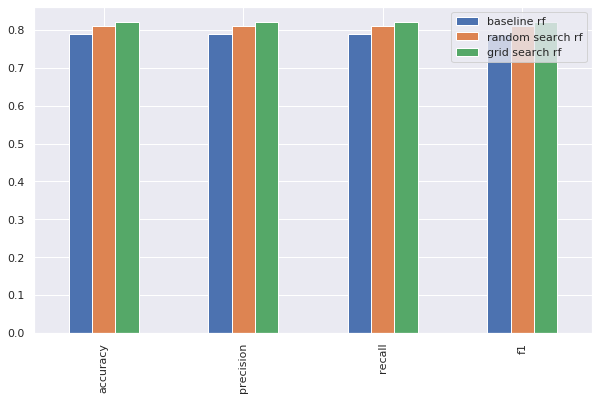

In [101]:
compare_rf_metrics = pd.DataFrame({
    'baseline rf': baseline_rf_metrics,
    'random search rf': rs_rf_metrics,
    'grid search rf': gs_rf_metrics
})

compare_rf_metrics.plot.bar(figsize=(10,6));

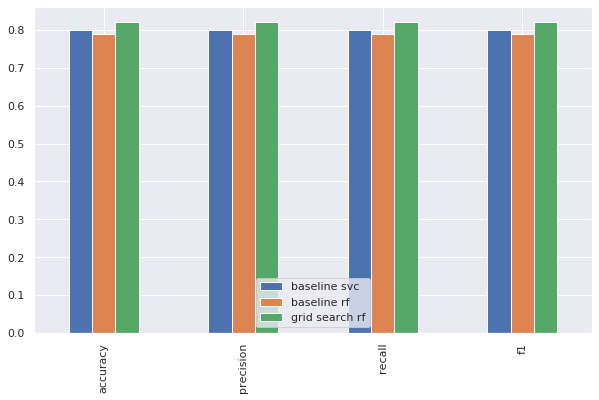

In [102]:
# Compare metrics between SVC and Random Forest
compare_metrics = pd.DataFrame({
    'baseline svc': baseline_svc_metrics,
    'baseline rf': baseline_rf_metrics,
    'grid search rf': gs_rf_metrics
})

compare_metrics.plot.bar(figsize=(10,6));

In [103]:
# Save model
import pickle

pickle.dump(gs_rf_clf, open("../data/gs_random_forest_model_2.pkl", "wb"))

In [106]:
# Load model and predict
loaded_model = pickle.load(open("../data/gs_random_forest_model_2.pkl", "rb"))

pickle_y_preds = loaded_model.predict(X_valid)
evaluate_preds(y_valid, pickle_y_preds)

Accuracy: 82.14%
Precison: 0.82
Recall: 0.82
F1 score: 0.82


{'accuracy': 0.82, 'precision': 0.82, 'recall': 0.82, 'f1': 0.82}

# Confusion Matrix

In [114]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_valid, pickle_y_preds)
cm

array([[83,  7],
       [13,  9]])

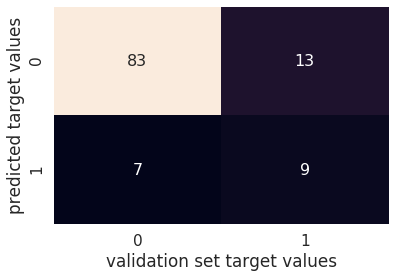

In [116]:
sns.set(font_scale=1.4)
sns.heatmap(cm.T, annot=True, fmt='d', annot_kws={"size": 16}, cbar=False)
plt.xlabel('validation set target values')
plt.ylabel('predicted target values');